# Stock Market Prediction Using Numerical Analysis and Textual Analysis
GRIP @ The Sparks Foundation  
Data Science & Business Analytics Intern
### by: Pham Quang Chi  


##### **Objective**: Predict the Indian Stock Exchange Sensitive Index - `SENSEX` from historical stock and news headlines data from 2015/01/01-31/03/2022.  

   
##### Data:  
###### - Stock price: https://bit.ly/36fFPI6  
###### - News Headlines: https://bit.ly/36fFPI6  


In [1]:
# install Huggingface Transformers with PyTorch dependency
#!pip install transformers[torch]

In [32]:
import numpy as np
import pandas as pd
from numba import vectorize
import matplotlib.pyplot as plt
import seaborn as sns
from re import sub
import yfinance as yf

# HuggingFace RoBERTa pipline model
from transformers import pipeline

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Random Forest model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error

# Numerical Data Pre-processing

In [3]:
# fetch Daily historical stock data from yahoo finance for BSE SENSEX 
# accordling with our news headlines datetime range
# which is from '2001-01-01' up until '2022-03-31
stock = yf.download('^BSESN', start='2015-01-01', end='2022-03-31')
stock.info()
stock.head()


[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2015-01-02 to 2022-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1781 non-null   float64
 1   High       1781 non-null   float64
 2   Low        1781 non-null   float64
 3   Close      1781 non-null   float64
 4   Adj Close  1781 non-null   float64
 5   Volume     1781 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.4 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [4]:
# check for missing values
stock.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Log-Returns of stock price
Arithmetic-returns: $r_{t} = price_{t} / price_{t-1} - 1$  
Arithmetic-returns are **multipicative** where:  
 $r_{t} = \prod_{t=1}^{T}(1+r_{t})$  

Log-returns: $z_{t} = \log(price_{t}) - \log(price_{t-1})$   
Log-returns are **additive** where:  
  $z_{t} = \sum_{t=1}^{T}\log(1+r_{t})$  
  
Log-returns are preferred over Arithmetic-returns based on the probability theory rule:
- The distribtution of the product of random variables is not identical to the distribution which the random varibles are drawn from.
- The distribtution of the sum of random variables is of the same type as the distribution of the random variables.
    
*Therefore we can attain a more stable distribution from Log-returns and a statistical model can be built with better accuracy*.

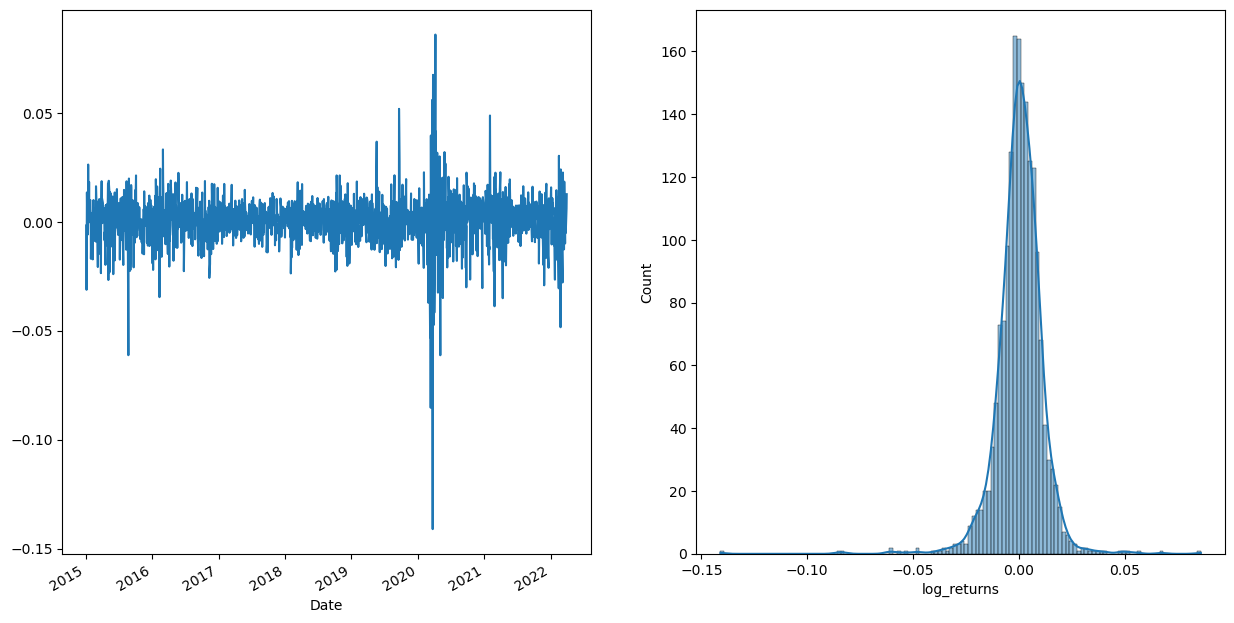

In [153]:
log_ret = np.log(stock['Adj Close']) - np.log(stock['Adj Close'].shift(1))
log_ret.dropna(inplace=True)
log_ret = log_ret.rename('log_returns')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
log_ret.plot(ax=ax[0])
sns.histplot(log_ret, kde=True, ax=ax[1]);

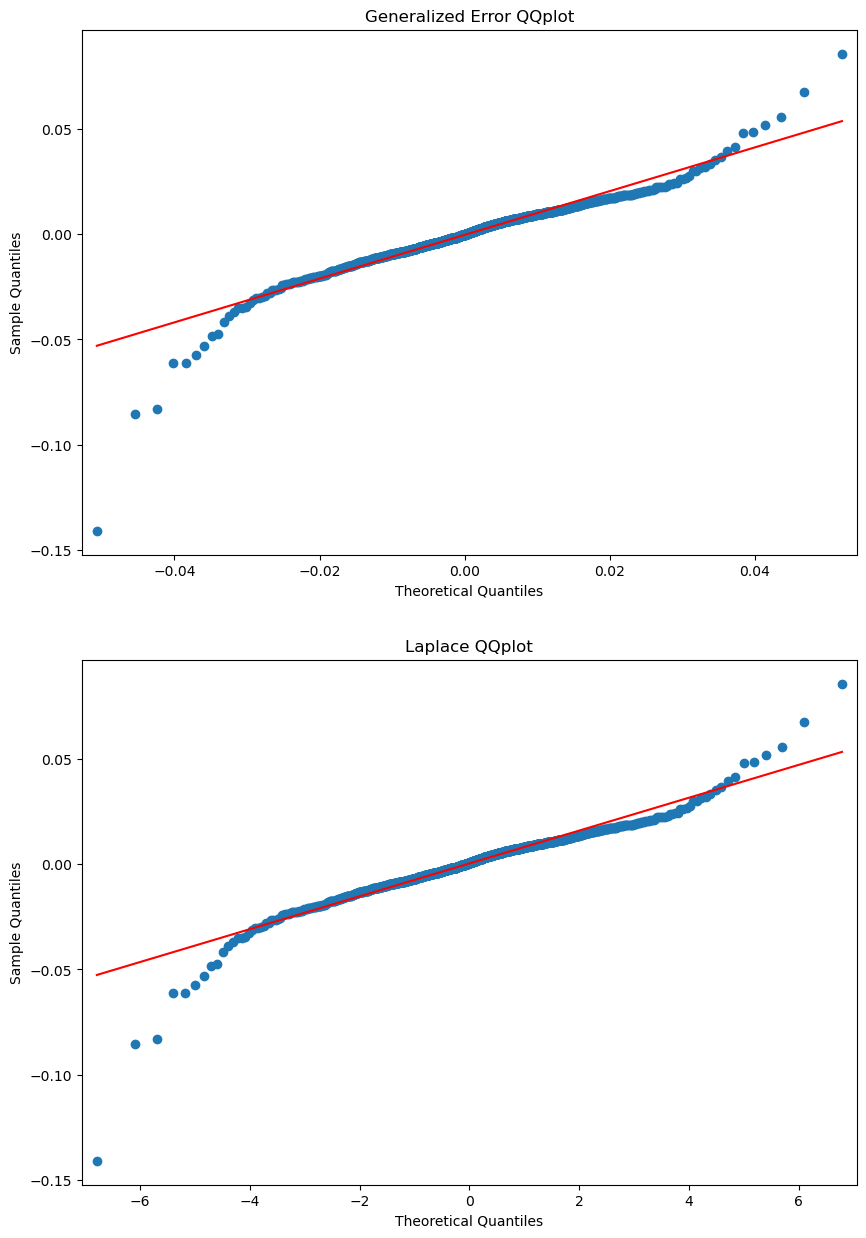

In [151]:
# QQ plots for Generalized Error and Laplace distributions
from scipy.stats import laplace, gennorm
# Fit a generalized normal distribution to the data
params = gennorm.fit(log_ret)

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
qqplot(log_ret, dist=gennorm(*params), line='r', ax=ax[0])
qqplot(log_ret, dist=laplace(), line='r', ax=ax[1])
ax[0].set_title('Generalized Error QQplot')
ax[1].set_title('Laplace QQplot');


In [7]:
# check for stationarity
adf_test = adfuller(log_ret, autolag='AIC')
# get p-value
adf_test[1]

3.689313269083327e-21

P-value < 0.05 -> Our data appears to be stationary

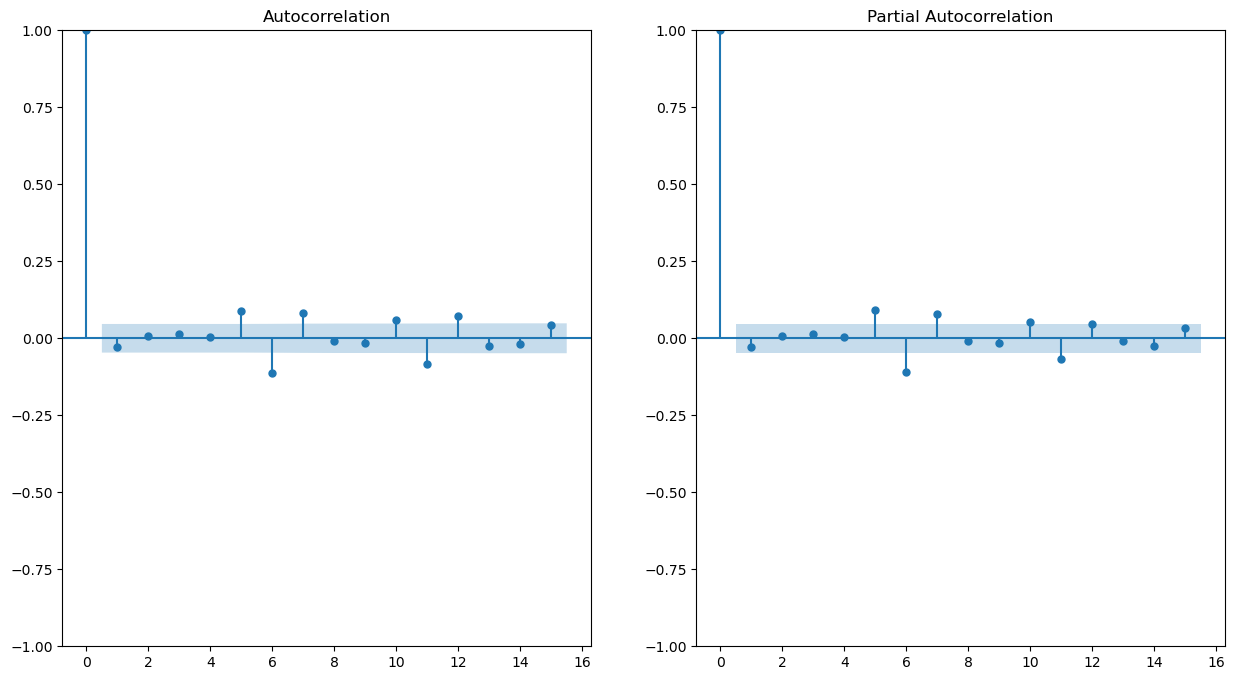

In [149]:
# plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
plot_acf(log_ret, lags=15, ax=ax[0])
plot_pacf(log_ret, lags=15, method='ywmle', ax=ax[1]);

The logarithms of returns do not have any significant autocorrelation

# Textual Data Pre-processing

In [9]:
# import the downloaded news headlines data
news = pd.read_csv(r"C:\Users\Steven\Downloads\india-news-headlines.csv", engine='c')
news.info()
news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [10]:
# parse date, rename and set as index
news['publish_date'] = pd.to_datetime(news['publish_date'], format='%Y%m%d')
news.rename(columns={'publish_date': 'Date'}, inplace=True)
news = news.set_index('Date')
# pertain the data post 2015-01-01
news = news['2015-01-01':]
# rename the `headline_text` column to `Headlines`
news.rename(columns={'headline_text': 'Headlines'}, inplace=True)
# remove the unecessary `headline_category` column
news = news.drop(['headline_category'], axis=1)

news.tail()

,Headlines
Date,
2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
2022-03-31,As Covid-19 cases drop to nil in southern dist...
2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...
2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [11]:
# our News data seems to have duplicates
# remove duplicate headlines
news.drop_duplicates(inplace=True)

In [12]:
# remove special characters in the headlines
clean_headlines = []
for i in range(0, len(news)):
    # The regular expression `\W+` matches any non-alphanumeric characters
    clean_headlines.append(sub(r'\W+', ' ', news['Headlines'][i]))

# replace with the cleaned headlines    
news['Headlines'] = clean_headlines
news['Headlines'][:5]


Date
2015-01-01    Breakfast recipe for diabetics Moong idlis
2015-01-01                Recipe Delicious coconut balls
2015-01-01                  Cure that dandruff naturally
2015-01-01                   Recipe Kerala Chicken curry
2015-01-01                           Recipe Mocha Coffee
Name: Headlines, dtype: object

In [13]:
# group headlines by date
grouped_news = news.groupby(['Date']).agg({'Headlines': '. '.join})
grouped_news.head()

,Headlines
Date,
2015-01-01,Breakfast recipe for diabetics Moong idlis. Re...
2015-01-02,Drink smart with these party tips. How to say ...
2015-01-03,3 Stylish New Year cocktail recipes you ll LOV...
2015-01-04,How to get that bikini body. Rules of love mak...
2015-01-05,Recipe Strawberry cupcakes. Recipe Kaju jeera ...


## Sentiment Analysis
using the Huggingface pretrained RoBERTa `cardiffnlp/twitter-roberta-base-sentiment-latest` model

In [14]:
# instantiate the full-classification model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax

# Define model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Define a function to perform sentiment analysis
def get_sentiments(df, column):
    sentiments = {"negative": [], "neutral": [], "positive": []}
    for text in df[column]:
        encoded_input = tokenizer(text, max_length=512, truncation=True, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = torch.nn.functional.softmax(torch.tensor(scores), dim=0)
        for i, label in enumerate(["negative", "neutral", "positive"]):
            sentiments[label].append(scores[i].item())
    return sentiments

sentiment_scores = get_sentiments(grouped_news, 'Headlines')

In [40]:
# Create our sentiment dataframe
sentiment_df = pd.DataFrame(sentiment_scores, index=grouped_news.index)
sentiment_df.head()

,negative,neutral,positive
Date,,,
2015-01-01,0.038320,0.668400,0.293279
2015-01-02,0.082853,0.680551,0.236596
2015-01-03,0.059572,0.514002,0.426426
2015-01-04,0.039752,0.587957,0.372292
2015-01-05,0.123824,0.772273,0.103903


# Model Development
In this section, we will use the last **60** days log-returns, trading volumns and sentiment scores (including current scores) as our 5 dimensional feature matrix to predict our target vector which is the current log-returns.  
2 models will be used for comparison are: `LSTM` and `Random Forest Regressor`


In [117]:
# merge the sentiment scores with shifted volumn data
yesterday_vol = stock['Volume'].shift(1).dropna()
df = pd.merge(yesterday_vol, sentiment_df.iloc[1:], how='inner', on='Date')
# merge the sentiment scores with the log returns data
df = pd.merge(log_ret, df, how='inner', on='Date')
# shift log returns by 1 day
log_prior_ret = log_ret.shift(1).dropna()
# merge df with the shifted log returns data
df = pd.merge(df.iloc[1:], log_prior_ret.rename('yesterday_log_returns'), how='inner', on='Date')
df.head()

,log_returns,Volume,negative,neutral,positive,yesterday_log_returns
Date,,,,,,
2015-01-06,-0.031185,9200.0,0.029923,0.313757,0.656320,-0.001636
2015-01-07,-0.002918,14100.0,0.046298,0.533188,0.420514,-0.031185
2015-01-08,0.013506,12200.0,0.084145,0.746031,0.169823,-0.002918
2015-01-09,0.006712,8200.0,0.314897,0.536853,0.148250,0.013506
2015-01-12,0.004610,11100.0,0.014138,0.528707,0.457155,0.006712


In [118]:
# convert to numpy array for model training
data = df.values

In [119]:
# Define the sliding window length
T = 60

## LSTM
This model is a two-layer LSTM network with 128 and 64 neurons respectively followed by two dense layers of 25 and 1 neurons.  
The model architecture is based on the following research paper:  
[Stock Price Prediction using Sentiment Analysis and Deep Learning for Indian Markets](https://arxiv.org/abs/2204.05783) 


In [134]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

# Convert to data matrix
def create_dataset(data, look_back=T):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 1:])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size,:], X[train_size:len(X),:]
LSTM_trainY, LSTM_testY = y[:train_size], y[train_size:len(y)]

# Reshape input data to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 5))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 5))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(T, 5)))
model.add(Dense(64))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, LSTM_trainY, epochs=100, batch_size=32, verbose=0)

# Make predictions
LSTM_trainPredict = model.predict(trainX)
LSTM_testPredict = model.predict(testX)



11/11 [==============================] - 0s 19ms/step


## Random Forest Regressor model 
  Statistical measures which are the mean, standard deviation, maximum, minimum and percentile values of the stock returns and sentiment scores are combined into a feature matrix as the input to the Random Forest Regressor model.

In [123]:
# Compute the statistical features for each window which are:
# the mean, standard deviation, maximum, minimum and percentile values 
# of the past log returns, past volumns and sentiment scores
features = []
for i in range(len(data) - T):
    window = data[i:i+T, 1:]
    mean = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    maximum = np.max(window, axis=0)
    minimum = np.min(window, axis=0)
    percentiles = np.percentile(window, [25, 50, 75], axis=0)
    feature_matrix = np.concatenate((mean, std, maximum, minimum, percentiles.flatten()))
    features.append(feature_matrix)

# Convert to NumPy array
features = np.array(features)

# Split into train and test sets
train_size = int(len(features) * 0.8)
trainX, testX = features[:train_size,:], features[train_size:len(features),:]
Forest_trainY, Forest_testY = data[T:T+train_size, 0], data[T+train_size:len(data), 0]

# Instantiate and fit the Random Forest Regressor model
# using default hyperparameters
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', n_jobs=-1, random_state=42)
model.fit(trainX, Forest_trainY)

# Make predictions
Forest_trainPredict = model.predict(trainX)
Forest_testPredict = model.predict(testX)


## Evaluate results

In [124]:
# Compute and compare the RMSE of our 2 models
# LSTM 
LSTM_trainScore = np.sqrt(mean_squared_error(LSTM_trainY, LSTM_trainPredict[:,0]))
print('LSTM Train Score: %.2f RMSE' % (LSTM_trainScore))
LSTM_testScore = np.sqrt(mean_squared_error(LSTM_testY, LSTM_testPredict[:,0]))
print('LSTM Test Score: %.2f RMSE' % (LSTM_testScore))
# Random Forest
Forest_trainScore = np.sqrt(mean_squared_error(Forest_trainY, Forest_trainPredict))
print('Random Forest Train Score: %.2f RMSE' % (Forest_trainScore))
Forest_testScore = np.sqrt(mean_squared_error(Forest_testY, Forest_testPredict))
print('Random Forest Test Score: %.2f RMSE' % (Forest_testScore))


LSTM Train Score: 0.09 RMSE
LSTM Test Score: 0.10 RMSE
Random Forest Train Score: 0.00 RMSE
Random Forest Test Score: 0.02 RMSE


In this particular project, the simplier model Random Forest Regressor appears to outperform the more complex LSTM model.